# Extract NECOFS data using NetCDF4-Python and analyze/visualize with Pandas

In [1]:
# Plot forecast water levels from NECOFS model from list of lon,lat locations
# (uses the nearest point, no interpolation)
import netCDF4
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from StringIO import StringIO
%matplotlib inline

In [2]:

#model='NECOFS Massbay'
#url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'

# GOM3 Grid
#model='NECOFS GOM3'
#url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'

model = 'NECOFS GOM3 Wave'
# forecast
#url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_WAVE_FORECAST.nc'
# archive
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/archives/necofs_gom3_wave'



In [3]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() + dt.timedelta(hours=-72)
stop = dt.datetime.utcnow() + dt.timedelta(hours=+72)

# ... or specific time (UTC)
start = dt.datetime(1991,1,1,0,0,0) + dt.timedelta(hours=+0)
start = dt.datetime(1992,7,1,0,0,0) + dt.timedelta(hours=+0)
start = dt.datetime(1992,8,1,0,0,0) + dt.timedelta(hours=+0)
start = dt.datetime(2016,1,1,0,0,0) + dt.timedelta(hours=+0)

stop = dt.datetime(2016,6,1,0,0,0) + dt.timedelta(hours=+0)



In [4]:
def dms2dd(d,m,s):
    return d+(m+s/60.)/60.
  

In [5]:
dms2dd(41,33,15.7)

41.55436111111111

In [6]:
-dms2dd(70,30,20.2)

-70.50561111111111

In [7]:
x = '''
Station, Lat, Lon
Falmouth Harbor,    41.541575, -70.608020
Sage Lot Pond, 41.554361, -70.505611
'''

In [8]:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Carolyn Seep Spot,    39.8083, -69.5917
Falmouth Harbor,  41.541575, -70.608020
'''

In [9]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Scituate Harbor,    42.199447, -70.720090
Scituate Beach,     42.209973, -70.724523
Falmouth Harbor,    41.541575, -70.608020
Marion,             41.689008, -70.746576
Marshfield,         42.108480, -70.648691
Provincetown,       42.042745, -70.171180
Sandwich,           41.767990, -70.466219
Hampton Bay,        42.900103, -70.818510
Gloucester,         42.610253, -70.660570
'''

In [10]:
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station')

-c:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [11]:
obs

,Lat,Lon
Station,,
Boston,42.368186,-71.047984
Scituate Harbor,42.199447,-70.720090
Scituate Beach,42.209973,-70.724523
Falmouth Harbor,41.541575,-70.608020
Marion,41.689008,-70.746576
Marshfield,42.108480,-70.648691
Provincetown,42.042745,-70.171180
Sandwich,41.767990,-70.466219
Hampton Bay,42.900103,-70.818510


In [12]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

In [13]:
# open NECOFS remote OPeNDAP dataset 
nc=netCDF4.Dataset(url).variables

In [14]:
# find closest NECOFS nodes to station locations
obs['0-Based Index'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,0-Based Index
Station,,,
Boston,42.368186,-71.047984,46065
Scituate Harbor,42.199447,-70.720090,45570
Scituate Beach,42.209973,-70.724523,45568
Falmouth Harbor,41.541575,-70.608020,43598
Marion,41.689008,-70.746576,47019
Marshfield,42.108480,-70.648691,42346
Provincetown,42.042745,-70.171180,40985
Sandwich,41.767990,-70.466219,44925
Hampton Bay,42.900103,-70.818510,41837


In [15]:
# Get desired time step  
time_var = nc['time']
istart = netCDF4.date2index(start,time_var,select='nearest')
istop = netCDF4.date2index(stop,time_var,select='nearest')

In [16]:
# get time values and convert to datetime objects
jd = netCDF4.num2date(time_var[istart:istop],time_var.units)

In [17]:
# get all time steps of water level from each station
nsta = len(obs)
z = np.ones((len(jd),nsta))
for i in range(nsta):
    z[:,i] = nc['hs'][istart:istop,obs['0-Based Index'][i]]
    

In [18]:
# make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z,index=jd,columns=obs.index)

In [19]:
# list out a few values
zvals.head()

Station,Boston,Scituate Harbor,Scituate Beach,Falmouth Harbor,Marion,Marshfield,Provincetown,Sandwich,Hampton Bay,Gloucester
2016-01-01 00:00:00.000,0.031104,0.039608,0.048368,0.311138,0.000109,0.577774,0.950669,0.088028,0.860809,0.154964
2016-01-01 01:01:52.500,0.031646,0.039443,0.049566,0.313438,0.001391,0.484846,0.879856,0.088229,0.891569,0.168038
2016-01-01 01:58:07.500,0.033063,0.040696,0.051615,0.304147,0.002084,0.687975,0.853385,0.089394,0.915612,0.178127
2016-01-01 03:00:00.000,0.033602,0.041261,0.052037,0.284162,0.004042,0.699799,0.802857,0.088585,0.893472,0.174667
2016-01-01 04:01:52.500,0.033108,0.040528,0.050960,0.260685,0.004650,0.712780,0.729302,0.086456,0.899192,0.168779


In [20]:
# model blew up producing very high waves on Jan 21, 2016
# eliminate unrealistically high values
mask = zvals>10.
zvals[mask] = np.NaN

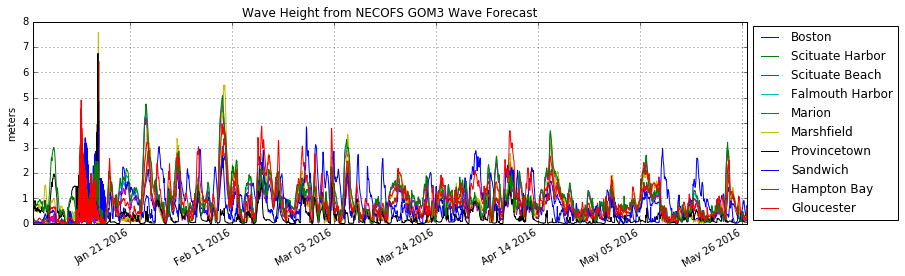

In [21]:
# plotting at DataFrame is easy!
ax=zvals.plot(figsize=(16,4),grid=True,title=('Wave Height from %s Forecast' % model),legend=False);
# read units from dataset for ylabel
plt.ylabel(nc['hs'].units)
# plotting the legend outside the axis is a bit tricky
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


In [22]:
# what is the maximum over the whole record at a specific location 
zvals['Boston'].max()

4.0912003517150879

In [23]:
# make a new DataFrame of maximum water levels at all stations
b=pd.DataFrame(zvals.idxmax(),columns=['time of max value (UTC)'])
# create heading for new column containing max water level
zmax_heading='zmax (%s)' % nc['hs'].units
# Add new column to DataFrame
b[zmax_heading]=zvals.max()

In [24]:
b

,time of max value (UTC),zmax (meters)
Station,,
Boston,2016-01-14 15:00:00.000,4.091200
Scituate Harbor,2016-01-14 15:00:00.000,4.865314
Scituate Beach,2016-01-14 15:00:00.000,6.448481
Falmouth Harbor,2016-02-09 01:58:07.500,4.866802
Marion,2016-02-09 01:58:07.500,4.704195
Marshfield,2016-01-14 13:01:52.500,7.597867
Provincetown,2016-01-14 10:58:07.500,6.754941
Sandwich,2016-02-26 07:58:07.500,3.842182
Hampton Bay,2016-02-09 01:58:07.500,5.088730
